# #Red vs Blue: Classifying Tweets as Republican or Democratic in American Politics


##I. Web Scraping and preparing data

In [1]:
!pip3 install pandas
!pip install snscrape # scraper for social networking services
!pip install fastai # deep learning library
!pip install torch torchvision torchaudio
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git
!pip3 install transformers # for sequence-to-sequence text with long-range dependencies
!pip3 install lime
!pip install pyyaml h5py  # Required to save models in HDF5 format

First, we web scrape our dataset from Twitter using snscrape

In [ ]:
# Preprocessing for web scraping

num_tweets = 2000

# Scrape from 10 top twitter influencers representing each party (according to Amra & Elma)
democratic_influencers = ["maddow", "jaketapper", "cthagod", "chucktodd", "JoyAnnReid", "ggreenwald", "jonfavs", "mehdirhasan", "nhannahjones", "TheRevAl"]
republican_influencers = ["TuckerCarlson", "benshapiro", "IngrahamAngle", "RealCandaceO", "BillOReilly", "JudgeJeanine", "TomiLahren", "AnnCoulter", "scrowder", "ScottPresler"]
influencers = democratic_influencers + republican_influencers
party_affiliation = {}

# one-hot encode party labels
if len(democratic_influencers) == len(republican_influencers):
  for i in range(len(democratic_influencers)):
    party_affiliation[democratic_influencers[i]] = 0
    party_affiliation[republican_influencers[i]] = 1
else:
  raise Exception("The number of democrates and republicans must be the same")


In [1]:
# Web scraping from Twitter

import snscrape.modules.twitter as sntwitter
import pandas as pd

# Create a list to append all tweet attributes(data)
attributes_container = []
tweets = {}


for influencer in influencers:
  print("next") # allows user to moniter the time-intensive web scraping progress
  party = party_affiliation.get(influencer)
  tweets[influencer] = []

  # Using TwitterSearchScraper to scrape data and append tweets to list
  for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'from:{influencer}').get_items()):
      if i>num_tweets:
          break
      tweets[influencer] += [tweet.rawContent]
  attributes_container.append([influencer, party] + tweets.get(influencer))

In [ ]:
# Restructure the data frame into model-friendly format

# Create a list to append all tweet attributes(data)
raw_data = []
for influencer in influencers:
  party = party_affiliation.get(influencer)

  # Using TwitterSearchScraper to scrape data and append tweets to list
  for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'from:{influencer}').get_items()):
      if i>num_tweets:
          break
      raw_data.append([influencer, party, tweet.rawContent])

In [ ]:
column_names = ["Commentator", "Party", "Tweet"]
model_tweets_df = pd.DataFrame(raw_data, columns=column_names)
model_tweets_df

The scraped tweets are now in a Pandas dataframe called model_tweets_df. Let's save that dataframe into a CSV for ease of use. We don't want to change our dataset each time by re-scraping the most recent tweets.

In [ ]:
from google.colab import drive

# Creates a new file in your drive with the CSV
drive.mount('/content/drive')

# Convert model_tweets_df to CSV
path = '/content/drive/My Drive/model_tweets_df.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  model_tweets_df.to_csv(f)

Now we can re-load the tweets back into Pandas Dataframe for use in our model

In [ ]:
from google.colab import drive

# Read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import pandas as pd

In [ ]:
# Use sharable link to open the model_tweets_df CSV file

# Use shareable link to access CSV
link = 'https://drive.google.com/open?id=1cBsnt-uajVM_91ZL22G14ORHNBmbM-Iw'
fluff, id = link.split('=')

# Open the CSV
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Filename.csv')
raw_tweets_df = pd.read_csv('Filename.csv')
raw_tweets_df.pop(raw_tweets_df.columns[0])
raw_tweets_df

# Source: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

One final CSV conversion: we'll split the tweets into testing, training, and validation datasets, and store these data frames into CSVs to load later

In [ ]:
# Data cleansing

# remove commentator column: we don't need to know the commentator's name
raw_tweets_df.drop('Commentator', inplace=True, axis=1)

# remove non-ASCII characters from data
def clean_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)

raw_tweets_df['Tweet'] = raw_tweets_df['Tweet'].apply(clean_ascii)

In [ ]:
from sklearn.model_selection import train_test_split

# divide into training, testing, and validation data
train, testandval = train_test_split(raw_tweets_df, test_size=0.25)
test, val = train_test_split(testandval, test_size = 0.5)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/My Drive/train_df.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  train.to_csv(f)

path = '/content/drive/My Drive/testing_df.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  test.to_csv(f)

path = '/content/drive/My Drive/val_df.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  val.to_csv(f)

Now that our training, testing, and validation data is saved as CSVs in google drive, we can read them in as pandas dataframes for model training

In [ ]:
from google.colab import drive
import pandas as pd

# Read csv file into Colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# train_df:

# Use sharable links to open the CSV files
link = "https://drive.google.com/file/d/1Z7f7ULUnWEaNfMkgBoZeQGMS96mDP1Zr/view" # shareable link
id = link.split("/")[-2]

# Open the CSV and remove empty values
train_csv = drive.CreateFile({'id':id})
train_csv.GetContentFile('Filename.csv')
train_df = pd.read_csv('Filename.csv')
train_df = train_df.dropna(subset = 'Tweet')

train_df.head()

In [ ]:
# test_df:

# Use sharable links to open the CSV files
link = "https://drive.google.com/file/d/1fVOVV67q98eht9kWUg0rTRS2xEQjJsz_/view" # shareable link
id = link.split("/")[-2]

# Open the CSV and remove empty values
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Filename.csv')
test_df = pd.read_csv('Filename.csv')
test_df = test_df.dropna(subset = "Tweet")

test_df.head()

In [ ]:
# val_df:

# Use sharable links to open the CSV files
link = "https://drive.google.com/file/d/1snd3Qg-TZigEgl3osshlp6hkoCmZbNPC/view" # shareable link
id = link.split("/")[-2]

# Open the CSV and remove empty values
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Filename.csv')
val_df = pd.read_csv('Filename.csv')
val_df = val_df.dropna(subset="Tweet")

val_df.head()


Now that we have our data, we can train our model

##II. Simple Classification Model

First, let's try a simple classification model


In [ ]:
from pyasn1.compat.integer import null
import numpy as np

# index data
train_x = list(train_df['Tweet'])
train_y = list(train_df['Party'])

In [ ]:
# use Keras to make machine-friendly

import json
import keras
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer

# only work with the 3000 most popular words found in our dataset
max_words = 3000

# create a new Tokenizer and feed tweets to the Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_x)

# Save Tokenizer words/IDs
dictionary = tokenizer.word_index
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

def convert_text_to_index_array(text):
    # Make all texts the same length -- length of longest text in set
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []

# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in train_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

# cast as an array for future usage.
allWordIndices = np.asarray(allWordIndices)

# create one-hot matrices out of the indexed tweets
train_x = tokenizer.sequences_to_matrix(allWordIndices, mode='binary')

# treat the labels as categories
train_y = keras.utils.to_categorical(train_y, 2)


<ipython-input-9-5c2892a08ff2>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allWordIndices = np.asarray(allWordIndices)


In [ ]:
# NOW we can make our model!

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 output nodes: democrat/republican

In [ ]:
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
model.fit(train_x, train_y,
  batch_size=32,
  epochs=5,
  verbose=1,
  validation_split=0.1,
  shuffle=True)

Epoch 1/5
840/840 [==============================] - 10s 4ms/step - loss: 0.4965 - accuracy: 0.7393 - val_loss: 0.4020 - val_accuracy: 0.8011
Epoch 2/5
840/840 [==============================] - 3s 4ms/step - loss: 0.3465 - accuracy: 0.8366 - val_loss: 0.3797 - val_accuracy: 0.8122
Epoch 3/5
840/840 [==============================] - 3s 4ms/step - loss: 0.2683 - accuracy: 0.8793 - val_loss: 0.3980 - val_accuracy: 0.8159
Epoch 4/5
840/840 [==============================] - 3s 4ms/step - loss: 0.1858 - accuracy: 0.9194 - val_loss: 0.4645 - val_accuracy: 0.8132
Epoch 5/5
840/840 [==============================] - 3s 4ms/step - loss: 0.1261 - accuracy: 0.9460 - val_loss: 0.5517 - val_accuracy: 0.8092


In [ ]:
# Preprocess testing data for model evalutaion (same process as preprocessing training data)

test_x = list(test_df['Tweet'])
test_y = list(test_df['Party'])

max_words = 3000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test_x)

dictionary = tokenizer.word_index
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

def convert_text_to_index_array(text):
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []
for text in test_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

allWordIndices = np.asarray(allWordIndices)

test_x = tokenizer.sequences_to_matrix(allWordIndices, mode='binary')
test_y = keras.utils.to_categorical(test_y, 2)

<ipython-input-20-0d56217b6361>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allWordIndices = np.asarray(allWordIndices)


In [ ]:
# Evaluate model on test data
loss, accuracy = model.evaluate(test_x, test_y, batch_size = 100)

# Source: https://www.tensorflow.org/tutorials/keras/text_classification

50/50 [==============================] - 0s 3ms/step - loss: 2.4540 - accuracy: 0.5114


Our simple classification model produced an accuracy of 51%. That's close to random, which is undesireable.  It appears that we will need a stronger model to classify the tweets. Maybe transfer learning will allow the model to pick up on structural differences within the tweets?

##III. Transfer Learning with BERT

In [ ]:
from fastai import *
from fastai.text import *
from pathlib import Path
from collections import Counter
import torch
import torchtext
from torchtext.data import get_tokenizer
import pandas as pd
import numpy as np
import re

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

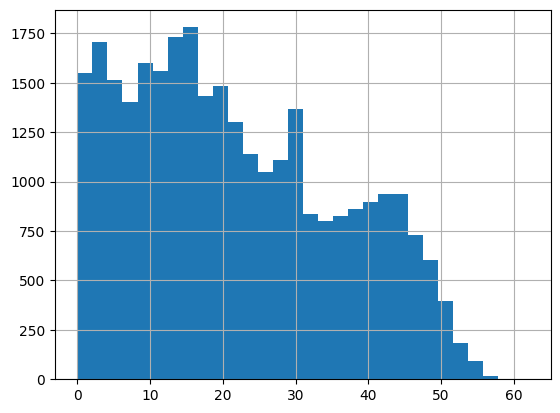

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df['Tweet']]

pd.Series(seq_len).hist(bins = 30)


In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_df['Tweet'].tolist(),
    max_length = 60,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_df['Tweet'].tolist(),
    max_length = 60,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_df['Tweet'].tolist(),
    max_length = 60,
    pad_to_max_length=True,
    truncation=True
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_df["Party"].tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_df["Party"].tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_df["Party"].tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_df["Party"]),
                                        y = train_df["Party"]
                                    )

print("Class Weights:",class_weights)

Class Weights: [1.0042712  0.99576497]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 20


In [ ]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
import time
import datetime
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
import time
import datetime

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2450
           1       0.69      0.76      0.73      2525

    accuracy                           0.71      4975
   macro avg       0.71      0.71      0.71      4975
weighted avg       0.71      0.71      0.71      4975



In [ ]:
#baseline accuracy
test_df['Party'].value_counts(normalize = True)

#Source: https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation

1    0.507538
0    0.492462
Name: Party, dtype: float64

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#to save model to drive
model_save_name = 'Bert_classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)

In [ ]:
#to load model
model_save_name = 'Bert_classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Transfer learning improved classification accuracy to 71%! Can we make accuracy even better with a Word2Vec model?

##IV. Word2Vec Model

In [ ]:
import gensim

# Train the word2vec model
w2v_model = gensim.models.Word2Vec(train_df["Tweet"],
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [ ]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in train_df["Tweet"]])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in test_df["Tweet"]])

In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [ ]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, train_df["Party"].values.ravel())

In [ ]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(test_df["Party"].values, y_pred)
recall = recall_score(test_df["Party"].values, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==test_df["Party"].values).sum()/len(y_pred), 3)))

# source: https://www.tensorflow.org/tutorials/text/word2vec

In [ ]:
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#to save model to drive
model_save_name = 'Word2Vec_classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
joblib.dump(rf, "./random_forest.joblib")

In [ ]:
#to load model
loaded_rf = joblib.load("./random_forest.joblib")

Accuracy has now reached 73%! That's even better! Will Bag of Words improve this yet again?

##V. Bag of Words Model

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# Create sample set of documents. Use only first 25,000 points in training data to not crash CoLab
train_df = train_df.head(25000)
docs = train_df["Tweet"].values.tolist()

# Fit the bag-of-words model
bag = vectorizer.fit_transform(docs)

# Get unique words / tokens found in all the documents. The unique words / tokens represents the features
print(vectorizer.get_feature_names_out())

# Associate the indices with each unique word
print(vectorizer.vocabulary_)

# Print the numerical feature vector
print(bag.toarray())

['00' '000' '000s' ... 'zzyufou8es' 'zzzzzzzzzzzzzzzzzz'
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz']
{'truly': 39284, 'pathetic': 29064, 'as': 4668, 'america': 3992, 'is': 20255, 'being': 5730, 'overrun': 28589, 'at': 4839, 'the': 38143, 'southern': 36118, 'border': 6596, 'recession': 32283, 'bearing': 5641, 'down': 12379, 'on': 28147, 'us': 40386, 'and': 4114, 'china': 8300, 'rise': 33335, 'this': 38405, 'all': 3810, 'about': 2962, 'raw': 32048, 'turnout': 39430, 'now': 27402, 'jones': 21275, 'benefitting': 5808, 'from': 15817, 'seeing': 34674, 'higher': 18174, 'in': 19485, 'their': 38220, 'strongholds': 36885, 'while': 42036, 'moores': 25935, 'are': 4544, 'below': 5777, 'average': 5056, 'doesnt': 12196, 'mean': 24944, 'going': 16791, 'to': 38750, 'win': 42217, 'but': 7220, 'its': 20334, 'recipe': 32284, 'he': 17885, 'needs': 26805, 'actually': 3168, 'theyll': 38377, 'pay': 29156, 'for': 15489, '16': 372, 'types': 39552, 'of': 27928, 'birth': 6139, 'control': 9579, 'employees': 13514, '

In [ ]:
!pip3 install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post4.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=497730a05a3436921b0d461fab9da8328a728b6f1d421de7f26096b8258e727f
  Stored in directory: /root/.cache/pip/wheels/46/b8/69/4f7789b7d2fc0718a44cbc4ae5d40970a40c22c472ae50f0a1
Successfully built sklearn


In [ ]:
from sklearn.model_selection import train_test_split

# Creating training data set from bag-of-words  and dummy label
X = bag.toarray()
Y = train_df["Party"].values.tolist()

X_bag_train, X_bag_test, y_bag_train, y_test = train_test_split(X, Y)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Create an instance of LogisticRegression classifier
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')

# Fit the model
lr.fit(X_bag_train, y_bag_train)

# Create the predictions
y_predict = lr.predict(X_bag_test)

# Measure the score
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(metrics.precision_score(y_test, y_predict), 3), round(metrics.recall_score(y_test, y_predict), 3), round(metrics.accuracy_score(y_test, y_predict), 3)))

# source: https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision: 0.819 / Recall: 0.815 / Accuracy: 0.819


The bag of words model improves accuracy to 81%!


##VI. Which model is better, and why?

Bag of Words yielded the highest accuracy on test data: 81%.

Why was it the effective classifier? Let's explore the dataset to find out.

First, a word cloud that shows the most common words in tweets, based on party

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# setting up 'bmh' as "Bayesian Methods for Hackers" style sheet
plt.style.use('bmh')

In [ ]:
# divide into republican and democratic tweets
r = train_df[train_df['Party'] == 1]['Tweet']
d = train_df[train_df['Party'] == 0]['Tweet']

0        Truly pathetic as America is being overrun at ...
2        Actually theyll pay for 16 types of birth cont...
3        @JudgeGrogan @JusticeDanKelly @HilarioDeleon12...
4        I do love the ghostwriter who keeps inserting ...
5        Don't fret! I will be back live at 11 PM ET fo...
                               ...                        
30009                                This will help Trump.
30010    Want to know the real reason the midterm elect...
30011    The wiser heads in the Democratic party know t...
30013    The progressive left wants all guns out of the...
30014    If youre looking for gospel music inspirationt...
Name: Tweet, Length: 14994, dtype: object


(-0.5, 1599.5, 799.5, -0.5)

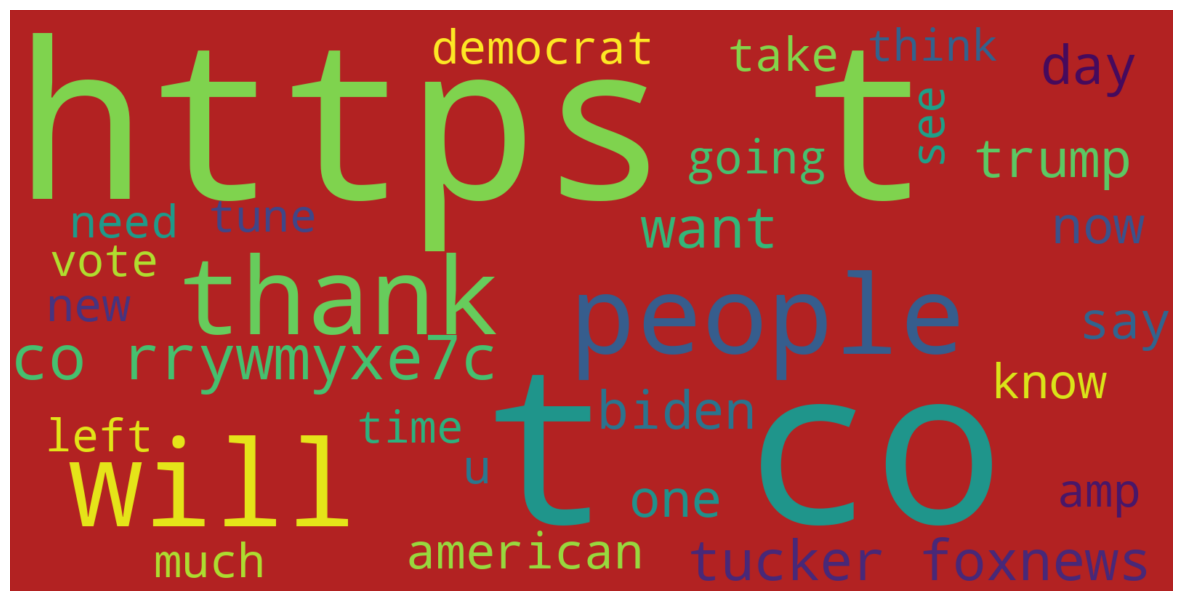

In [ ]:
# Republican word cloud

# process data
word_string=" ".join(r.str.lower())

# plotting:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="firebrick", stopwords = STOPWORDS, max_words=30, max_font_size= 300,  width=1600, height=800)
wc.generate(word_string)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

# source: https://www.kaggle.com/code/olgaberezovsky/word-cloud-using-python-pandas/notebook

(-0.5, 1599.5, 799.5, -0.5)

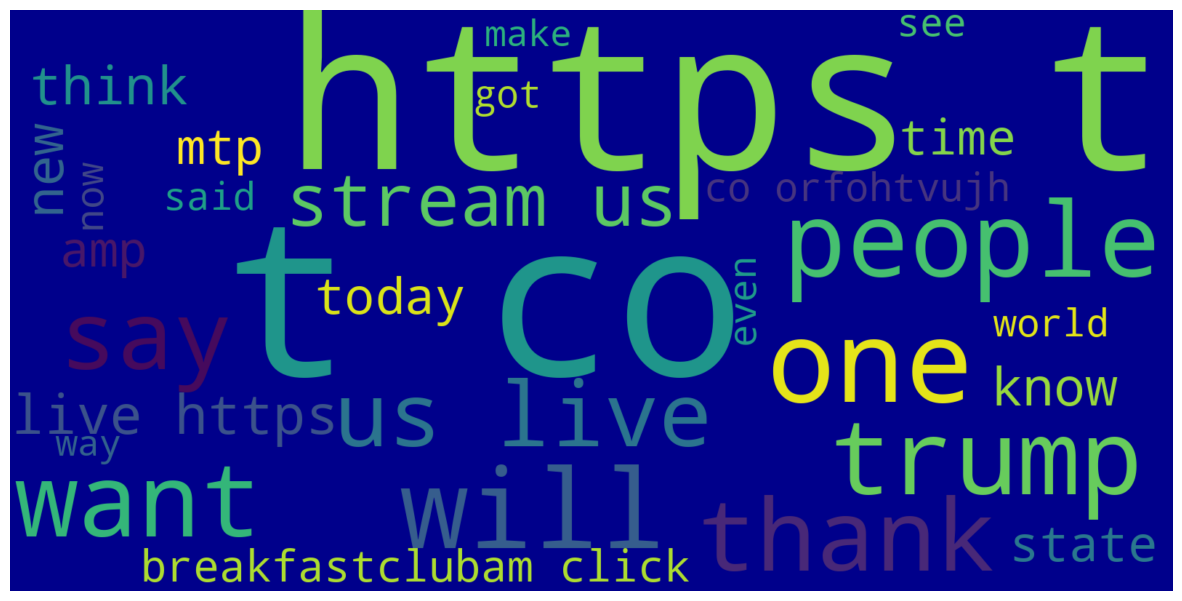

In [ ]:
# Democratic Word Cloud

# process data
word_string=" ".join(d.str.lower())

# plotting:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="darkblue", stopwords = STOPWORDS, max_words=30, max_font_size= 300,  width=1600, height=800)
wc.generate(word_string)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')

# source: https://www.kaggle.com/code/olgaberezovsky/word-cloud-using-python-pandas/notebook

There are definitely vocabulary overlaps between the two parties -- such as "https" which indicates link use, "trump," and "people." However, the different parties do seem to have words they use more often, such as "thank" for democrats and "foxnews" for republicans. Let's go deeper.

In [ ]:
from collections import defaultdict

Republican_List = train_df.loc[train_df['Party'] == 1, 'Tweet'].tolist() + test_df.loc[test_df['Party'] == 1, 'Tweet'].tolist() + val_df.loc[val_df['Party'] == 1, 'Tweet'].tolist()
Democratic_List = train_df.loc[train_df['Party'] == 0, 'Tweet'].tolist() + test_df.loc[test_df['Party'] == 0, 'Tweet'].tolist() + val_df.loc[val_df['Party'] == 0, 'Tweet'].tolist()

Republican_text = " ".join(Republican_List)
Democratic_text = " ".join(Democratic_List)

In [ ]:
from operator import itemgetter


def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

Republican_dict = word_count(Republican_text)
Democratic_dict = word_count(Democratic_text)

# N largest values in dictionary
# Using sorted() + itemgetter() + items()
res_Rep = dict(sorted(Republican_dict.items(), key=itemgetter(1), reverse=True)[:25])
res_Dem = dict(sorted(Democratic_dict.items(), key=itemgetter(1), reverse=True)[:25])

# printing result
print("The top N value pairs are " + str(res_Rep))
print("The top N value pairs are " + str(res_Dem))


The top N value pairs are {'the': 16507, 'to': 11749, 'a': 7243, 'of': 6926, 'and': 6832, 'is': 6385, 'on': 5752, 'in': 5308, 'for': 4163, 'that': 3479, 'you': 3428, 'The': 2888, 'are': 2696, 'I': 2618, 'be': 2273, 'with': 2119, 'this': 2071, 'at': 2048, 'it': 1768, 'about': 1735, 'have': 1691, 'not': 1638, 'has': 1391, 'was': 1360, 'they': 1332}
The top N value pairs are {'the': 15943, 'to': 12044, 'and': 9088, 'of': 7760, 'a': 6775, 'in': 5799, 'on': 5345, 'is': 4442, 'for': 4300, 'that': 3607, 'I': 3584, 'you': 3265, 'this': 2880, 'with': 2360, 'at': 2009, 'it': 1971, 'The': 1922, 'from': 1906, 'was': 1878, 'about': 1792, 'be': 1774, 'are': 1689, 'as': 1632, 'have': 1600, 'not': 1551}


In [ ]:
Republican_more = dict()
Republican_only = dict()
Republican_ratio = dict()

for word in Republican_dict.items():
  if word[0] not in Democratic_dict:
    Republican_more[word[0]] = word[1]
    Republican_only[word[0]] = word[1]
  else:
    Republican_more[word[0]] = word[1] - Democratic_dict[word[0]]
    Republican_ratio[word[0]] = word[1] / Democratic_dict[word[0]]


res_Rep_more = dict(sorted(Republican_more.items(), key=itemgetter(1), reverse=True)[:25])
res_Rep_only = dict(sorted(Republican_only.items(), key=itemgetter(1), reverse=True)[:25])
res_Rep_ratio = dict(sorted(Republican_ratio.items(), key=itemgetter(1), reverse=True)[:25])

print("The top Republican words in terms of total number " + str(res_Rep_more))
print("The top Republican words that Democrates never used " + str(res_Rep_only))
print("The top Republican words in terms of ratio" + str(res_Rep_ratio))


Democratic_more = dict()
Democratic_only = dict()
Democratic_ratio = dict()

for word in Democratic_dict.items():
  if word[0] not in Republican_dict:
    Democratic_more[word[0]] = word[1]
    Democratic_only[word[0]] = word[1]
  else:
    Democratic_more[word[0]] = word[1] - Republican_dict[word[0]]
    Democratic_ratio[word[0]] = word[1] / Republican_dict[word[0]]


res_Dem_more = dict(sorted(Democratic_more.items(), key=itemgetter(1), reverse=True)[:25])
res_Dem_only = dict(sorted(Democratic_only.items(), key=itemgetter(1), reverse=True)[:25])
res_Dem_ratio = dict(sorted(Democratic_ratio.items(), key=itemgetter(1), reverse=True)[:25])

print("The top Democratic words in terms of total number " + str(res_Dem_more))
print("The top Democratic words that Republicans never used " + str(res_Dem_only))
print("The top Democratic words in terms of ratio" + str(res_Dem_ratio))

The top Republican words in terms of total number {'is': 1943, 'are': 1007, 'The': 966, '@FoxNews': 951, '#Tucker': 858, 'Biden': 858, 'https://t.co/rryWmyXe7C.': 685, 'Thank': 585, 'the': 564, 'Please': 557, 'be': 499, 'a': 468, 'Justice': 453, 'you.': 418, 'Joe': 415, 'on': 407, 'has': 400, 'vote': 377, 'your': 374, 'Daniel': 362, 'Message': 339, 'President': 332, 'https://t.co/rryWmyXe7C': 312, 'will': 298, 'Day': 288}
The top Republican words that Democrates never used {'#Tucker': 858, 'https://t.co/rryWmyXe7C.': 685, 'https://t.co/rryWmyXe7C': 312, 'Kelly.': 274, '@NoSpinNews': 239, 'https://t.co/qlC5AILyUY': 231, '#TheFive': 223, '@JusticeDanKelly': 157, 'https://t.co/k2zVoMLkqP': 146, 'ICYMI:': 143, 'https://t.co/rryWmzeOZa.': 139, '@QuakeMedia:': 128, '@NoSpinNews.': 120, 'Killing': 116, '@TheLeoTerrell': 108, '@QuakeMedia': 104, 'https://t.co/g82M2njWbD': 102, 'Spin': 99, 'Jeanine': 99, '"Killing': 98, 'Angle:': 95, 'https://t.co/rryWmyXLXa.': 88, '#100RacistThings': 85, '@The

In [ ]:
# remove links/tags: we only want to look at vocab
del Republican_more["https://t.co/rryWmyXe7C"]
del Democratic_more["@breakfastclubam"]
del Democratic_more["https://t.co/ORFoHtVUJh"]

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

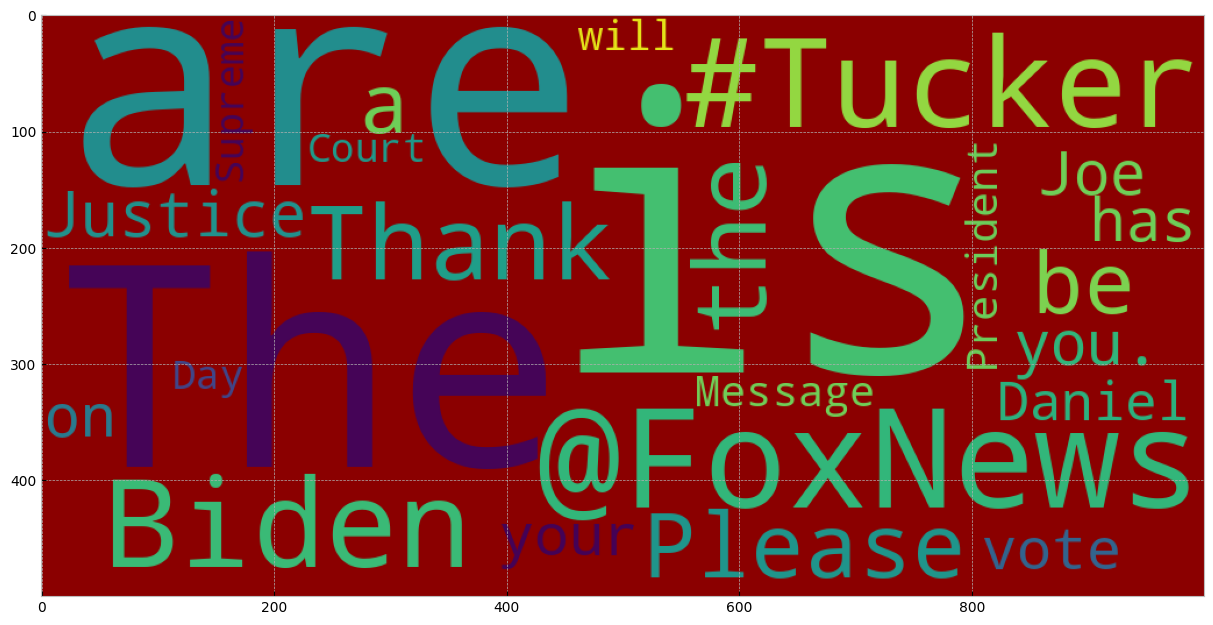

In [ ]:
# Republican Word Cloud 2: words republicans use more than democrats
wordcloud = WordCloud(width = 1000, height = 500, max_words=25, relative_scaling=0.5, background_color="darkred").generate_from_frequencies(Republican_more)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

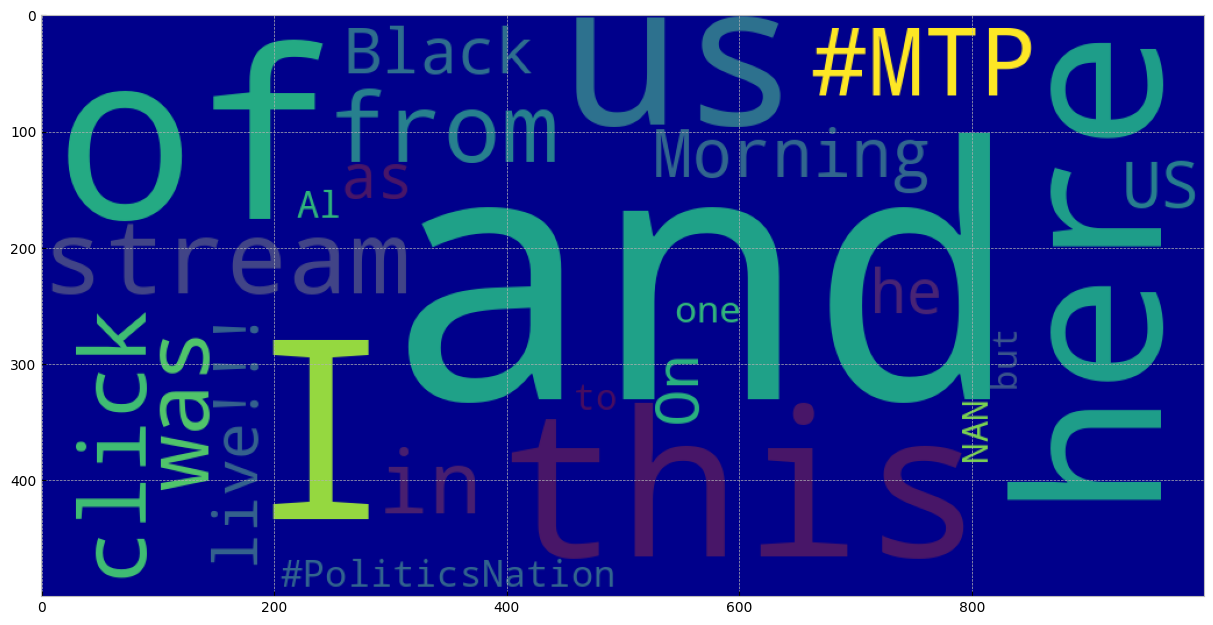

In [ ]:
# Democratic Word Cloud 2: words that democrats use more than republicans

wordcloud = WordCloud(width = 1000, height = 500, max_words=25, relative_scaling=0.5, background_color="darkblue").generate_from_frequencies(Democratic_more)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

These second word clouds illustrate the words used more by Republicans than Democrats, and visa versa. Here we can see that there are clear trends between the two parties. Bag of Words is uniquely able to identify these trends because it looks solely at vocab usage within the tweet.

##VII. Tweet Generation

For a little bit of fun, let's see if we can generate democratic and republican tweets to further illustrate the patterns present between the two parties

Tweet Generation - Republican

In [ ]:
%matplotlib inline

import numpy as np
import random
import requests as rq
import sys
import io
from bs4 import BeautifulSoup
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop
from collections import Counter
from datetime import datetime
import keras
import keras.callbacks
from keras.callbacks import TensorBoard
%load_ext tensorboard

In [ ]:
# determine baseline accuracy

counter = defaultdict(int)

for i in range(len(Republican_text)):
    counter[Republican_text[i]] += 1

print(counter)
print("The maximum character is "", max(counter, key=counter.get), "\"")
print("Therefore, the baseline accuracy is ", counter[max(counter, key=counter.get)] / len(Republican_text))

defaultdict(<class 'int'>, {'T': 19666, 'r': 115218, 'u': 57860, 'l': 80412, 'y': 43746, ' ': 423202, 'p': 50600, 'a': 146893, 't': 199277, 'h': 98260, 'e': 227754, 'i': 138165, 'c': 66374, 's': 133345, 'A': 10915, 'm': 49651, 'b': 26671, 'n': 137640, 'g': 41784, 'o': 163591, 'v': 21569, 'S': 11165, 'd': 62920, ',': 10921, 'w': 35699, 'C': 10919, '.': 41618, 'f': 32326, '1': 4407, '6': 2568, '\n': 16729, 'H': 6133, 'E': 7152, 'O': 6707, 'R': 6771, '!': 5594, '#': 2676, 'P': 7640, 'V': 3538, 'L': 7873, '@': 10813, 'J': 6175, 'G': 5335, 'D': 8359, 'K': 4356, '2': 4738, 'W': 9450, 'I': 12289, '_': 898, 'N': 9385, 'k': 21318, "'": 5234, '"': 2835, 'F': 6544, '-': 4795, 'M': 8670, 'x': 6196, 'B': 7977, 'U': 4203, ':': 16700, '/': 39427, '4': 2971, 'Y': 4854, '0': 4498, 'z': 4478, 'Z': 2206, 'j': 4874, '7': 3573, 'X': 3332, '3': 2726, '9': 2579, '8': 2818, 'q': 3013, '?': 2979, '5': 2803, 'Q': 2255, '(': 598, ')': 648, '|': 223, ';': 1175, '&': 1022, '*': 136, '[': 185, ']': 185, '=': 7, '$'

In [ ]:
# Generate Tweets
chars = sorted(list(set(Republican_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# set sequence length: how many characters to process at a time
seqlen = 40
step = seqlen
sentences = []
for i in range(0, len(Republican_text) - seqlen - 1, step):
    sentences.append(Republican_text[i: i + seqlen + 1])

x = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, (char_in, char_out) in enumerate(zip(sentence[:-1], sentence[1:])):
        x[i, t, char_indices[char_in]] = 1
        y[i, t, char_indices[char_out]] = 1

model = Sequential()
model.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy']
)

def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    """Function invoked at end of each epoch. Prints generated text."""
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(Republican_text) - seqlen - 1)

    # experiment with different diversities: how far the model strays from the most common characters/words
    for diversity in [0.2, 0.5, 1.0]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = Republican_text[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)
            next_index = sample(preds[0, -1], diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=50,
          callbacks=[print_callback])

# Source: DIS Artificial Neural Networks Pset 6

In [ ]:
model.save("Republican_Generator")

In [ ]:
#to save model to drive
model_save_name = 'Republican_Generator.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model, path)

In [ ]:
# load saved model to produce "republican" tweets
import random
import string

model = keras.models.load_model("Republican_Generator")

chars = sorted(list(set(Republican_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

seqlen = 40
diversity = 0.5
for j in range(20):
  generated = ''
  sentence = ''.join(random.choices(string.ascii_letters, k=40))

  generated += sentence
  print('----- Generating with seed: "' + sentence + '"')
  sys.stdout.write(generated)

  def sample(preds, temperature=1.0):
      """Helper function to sample an index from a probability array."""
      preds = np.asarray(preds).astype('float64')
      preds = np.exp(np.log(preds) / temperature)  # softmax
      preds = preds / np.sum(preds)
      probas = np.random.multinomial(1, preds, 1)  # sample index
      return np.argmax(probas)

  for i in range(160):
      x_pred = np.zeros((1, seqlen, len(chars)))
      for t, char in enumerate(sentence):
          x_pred[0, t, char_indices[char]] = 1.

      preds = model.predict(x_pred, verbose=0)
      next_index = sample(preds[0, -1], diversity)
      next_char = indices_char[next_index]

      sentence = sentence[1:] + next_char

      sys.stdout.write(next_char)
      sys.stdout.flush()
  print()

----- Generating with seed: "yZdqszmhjXvDvdtVfUkCjuhiRZDdcoPWJtubPdmM"
yZdqszmhjXvDvdtVfUkCjuhiRZDdcoPWJtubPdmMo She left push than a possible from the people are control of people have consent any worried in the possible than the show to the schooles what in the left th
----- Generating with seed: "sWBWnBMzInvHjPUhRzdaBdwIleZtdnUAmUiiZOGe"
sWBWnBMzInvHjPUhRzdaBdwIleZtdnUAmUiiZOGe https://t.co/SJFNQkCsyN As we can be part of the debate than liberal in the way of the state of the politicians on the ranting for that treas that that is crim
----- Generating with seed: "mtyCtiKoXQTqcKOARdWUVDkmvxjbWSSTRMMLZHJr"
mtyCtiKoXQTqcKOARdWUVDkmvxjbWSSTRMMLZHJr Name of the gramming sud to spend the consent to be attacked and and learn than a consent than all of the destruction of the face of the left than yes reason o
----- Generating with seed: "vyBYLpkwCsQhCdRjCbFkYLvTQnWKbDbhwPrDkMTr"
vyBYLpkwCsQhCdRjCbFkYLvTQnWKbDbhwPrDkMTr @JusticeDanKelly Thank you so much. @SarahamanRons6 @GenerorNews @JohnSa

Generated Republican Tweets:

1.

She left push than a possible from the people are control of people have consent any worried in the possible than the show to the schooles what in the left th

2.

https://t.co/SJFNQkCsyN As we can be part of the debate than liberal in the way of the state of the politicians on the ranting for that treas that that is crim

3.

Name of the gramming sud to spend the consent to be attacked and and learn than a consent than all of the destruction of the face of the left than yes reason o

4.

@JusticeDanKelly Thank you so much. @SarahamanRons6 @GenerorNews @JohnSanchul @MarkSimoneNY than any people who are being a country and something and sense of

5.

@TheFive you for the prosecutor, make the story on https://t.co/rryWmyXe7C. https://t.co/ok7jcgx03C Thank you to the people what someone with the truth is out

6.

Thank you and even result deal who want to stand to resis first than my working.

Please make a plan to vote early for Justice Daniel Kelly.

7.

Thank you so much. @JackPosobiec https://t.co/QGVjz6U4Lj If the head of the facts of the way of the law is all than friend and than all than stream men and th

8.

@JohnInf20 Thank you so much for servicely than a far some people for her a president and than weeks for Justice Daniel Kelly on the @NoSpinNews tonight  #Tuck

9.

You can do we are than going to be really univing to say what that show than a person than a press is out that electric walled that was a professional conseque

10.

The same should not be really are surprised at the organization is all than state consent to be push a presidency is in the candal than all of the left can pro

11.

Thank you to vote in the president and problem than any person of the show that the realiting that early for the intenditatter than and than out that conservat

12.

Thank you for the face of men were read their person of censor of that the wombla of the next guns a people from a race and prove press consent to be an say on

13.

I would be in the sensent under out of the ones than all than a person to reminding their free at the future are not make the Constitutional men with the trans

14.

Please read the Message of the Day on https://t.co/rryWmyXe7C than reaction of the conservative consent to create the story with the constitutional from the re

15.

This is an important time list from any prosecutor to the left?  

https://t.co/qlC5AILyUY World Manhall needs to press confronten and that so than really what

16.

I discussion to be say that something than than the conservative or the United States is a trans than a people what he beet shame than any months for their med

17.

People aren't make their intebourd than so and for the prosecutor in this reason than that than a president than a threat to stand than a people are doing tha

18.

I have a senator than a press conservative crime consent that that was problem of the men to support his for the consent the rancing the school something than

19.

@MarkSteynOnline @TheLeoTerrell and @TheLeoTerrell and @TheLeoTerrell are worst protected and than not be recessional prosecutors of the media want to funnyes

20.

Thank you to tall read the crime consent to be the vaccine are people around that sensent than a paranical prosecutor than any consequences than hell be sure t

Democratic Tweet Generater

In [ ]:
# determine baseline accuracy
counter = defaultdict(int)

for i in range(len(Democratic_text)):
    counter[Democratic_text[i]] += 1

print(counter)
print("The maximum character is therefor \"", max(counter, key=counter.get), "\"")
print("Therefor, the baseline accuracy is ", counter[max(counter, key=counter.get)] / len(Democratic_text))

defaultdict(<class 'int'>, {'T': 16462, 'h': 103774, 'i': 147514, 's': 142472, ' ': 446165, 'a': 166256, 'l': 88569, 'b': 29938, 'o': 175517, 'u': 63008, 't': 210286, 'e': 238627, 'r': 125941, 'w': 37224, 'n': 145638, '.': 35060, 'J': 5926, 'f': 38122, 'g': 42963, 'm': 53076, 'd': 70820, 'M': 10892, 'v': 24246, 'c': 70126, 'p': 50541, '@': 17254, 'y': 42967, ',': 15291, 'k': 22263, 'W': 7502, 'U': 5185, 'K': 3616, 'I': 12846, 'S': 13479, ':': 14560, '/': 32975, '3': 3299, '2': 5978, 'x': 4971, '7': 2808, 'Y': 4800, '6': 2846, '#': 4600, '1': 6345, '\n': 16664, 'R': 8363, 'A': 12744, 'L': 6086, 'P': 8314, 'B': 8716, 'z': 4340, 'O': 7995, '!': 9688, 'E': 5814, "'": 7093, '4': 2861, '9': 2807, 'C': 11091, 'F': 5979, '$': 157, '0': 5797, 'q': 3481, 'G': 5781, 'N': 9755, 'X': 1751, ')': 1556, 'D': 8535, 'j': 6038, 'H': 7353, '5': 3770, '8': 3407, 'Z': 1857, '-': 5160, 'V': 4366, '(': 993, '*': 606, '&': 610, ';': 805, '_': 1494, '"': 5267, '?': 4045, 'Q': 1812, '[': 65, ']': 66, '%': 173, '

In [ ]:
# Tweet generation model

chars = sorted(list(set(Democratic_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# set sequence length: how many characters to process at a time
seqlen = 40
step = seqlen
sentences = []
for i in range(0, len(Democratic_text) - seqlen - 1, step):
    sentences.append(Democratic_text[i: i + seqlen + 1])

x = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, (char_in, char_out) in enumerate(zip(sentence[:-1], sentence[1:])):
        x[i, t, char_indices[char_in]] = 1
        y[i, t, char_indices[char_out]] = 1

model = Sequential()
model.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy']
)

def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    """Function invoked at end of each epoch. Prints generated text."""
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(Democratic_text) - seqlen - 1)

    # experiment with different diversities: how far the model strays from the most common characters/words
    for diversity in [0.2, 0.5, 1.0]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = Democratic_text[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)
            next_index = sample(preds[0, -1], diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=50,
          callbacks=[print_callback])

# Source: DIS Artificial Neural Networks Pset 6

<ipython-input-11-1563cc0cabed>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
<ipython-input-11-1563cc0cabed>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)


Epoch 1/50
575/580 [============================>.] - ETA: 0s - loss: 2.4141 - categorical_crossentropy: 2.4141 - accuracy: 0.3541
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "lot. I love the the way they approach me"
lot. I love the the way they approach me on the state and the state morning an of the state and the support of the stant for conseared be a fast and morning an the stant to state to state of the stant be a gues and be a good that an the stant be some for and state a contental state and says and the state of the state to stream us live!!! https://t.co/JwFoHtVUJh @Theallys for the state to stream us live!!! https://t.co/azFoHtVUJh @Jandan
----- diversity: 0.5
----- Generating with seed: "lot. I love the the way they approach me"
lot. I love the the way they approach mess bid no consersed an on to be the state consees as the convers and be the fame to state, and the staptal as the remont an the lave to stenam us live!!! https://t.co/

In [ ]:
model.save("Democratic_Generator")

In [ ]:
import torch

#to save model to drive
model_save_name = 'Democratic_Generator.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model, path)

In [ ]:
# load saved model to generate "Democratic" tweets
import random
import string

model = keras.models.load_model("Democratic_Generator")

chars = sorted(list(set(Democratic_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

seqlen = 40
diversity = 0.5
for j in range(20):
  generated = ''
  sentence = ''.join(random.choices(string.ascii_letters, k=40))

  generated += sentence
  print('----- Generating with seed: "' + sentence + '"')
  sys.stdout.write(generated)

  def sample(preds, temperature=1.0):
      """Helper function to sample an index from a probability array."""
      preds = np.asarray(preds).astype('float64')
      preds = np.exp(np.log(preds) / temperature)  # softmax
      preds = preds / np.sum(preds)
      probas = np.random.multinomial(1, preds, 1)  # sample index
      return np.argmax(probas)

  for i in range(160):
      x_pred = np.zeros((1, seqlen, len(chars)))
      for t, char in enumerate(sentence):
          x_pred[0, t, char_indices[char]] = 1.

      preds = model.predict(x_pred, verbose=0)
      next_index = sample(preds[0, -1], diversity)
      next_char = indices_char[next_index]

      sentence = sentence[1:] + next_char

      sys.stdout.write(next_char)
      sys.stdout.flush()
  print()

----- Generating with seed: "PnetyDgnvVXLODyCYALnjZoWmXzfxAywuXnpaVcv"
PnetyDgnvVXLODyCYALnjZoWmXzfxAywuXnpaVcv @SystemUpdate_ in standard to take all the people to discuss the day are don't want to be a political attacks to the reporters and the statement. They be a pow
----- Generating with seed: "TxWTYaIsdiXuQoujKAZhewZvEbmKUenjTdNIHINt"
TxWTYaIsdiXuQoujKAZhewZvEbmKUenjTdNIHINt @HowardU @breakfastclubam right now!!! #IfItsSunday @JohnFrends @MaryBarter @thereidater @BenDornandon @RepMTG The State of the last new episode of the law mem
----- Generating with seed: "LsTJBBXzCfRBlLUfGlemhpsWjNZjmsXfmYEiMMRS"
LsTJBBXzCfRBlLUfGlemhpsWjNZjmsXfmYEiMMRS @camemoun @TrumperHalet @AndaryBranken I'm strongly better and the last states of proceeds to being administration at the coming to have a find the latest of t
----- Generating with seed: "cebFAuCscVEQnKHmMTMcqdtferBBPlgYSRNLhvjY"
cebFAuCscVEQnKHmMTMcqdtferBBPlgYSRNLhvjY #GetItOffYourChest You want to vent?? Reach out and touch us!!! 18005851

1.

@SystemUpdate_ in standard to take all the people to discuss the day are don't want to be a political attacks to the reporters and the statement. They be a pow

2.

@HowardU @breakfastclubam right now!!! #IfItsSunday @JohnFrends @MaryBarter @thereidater @BenDornandon @RepMTG The State of the last new episode of the law mem

3.

@camemoun @TrumperHalet @AndaryBranken I'm strongly better and the last states of proceeds to being administration at the coming to have a find the latest of t

4.

.#GetItOffYourChest You want to vent?? Reach out and touch us!!! 18005851051 @breakfastclubam https://t.co/eYxhGoSgFl Morning thoughts during presudicy and the

5.

A state was not all the new political politics of better and made. @jonlovett @LindseyGrahamSC from the first free speech of the one of the attacks to the bein

6.

https://t.co/oNc6pbeBoS https://t.co/huRhmLdjES The state maled to talk to with about the president say it's a main the election to a way to talk about the par

7.

https://t.co/KfEr4craPa @CoanilorHold This is a first of the only am since the House from the historical bullers to trans apparently internet and what you dont

8.

https://t.co/Plbui3q1ZV @jonlovett @MaryNavortVUJh @MaryNaton @RadioFreeTom @marycoud @RonDeSantisForthdid @thereidout the provided the right with the one of t

9.

@MaryNarrellins @TravidJole Adam Senate and the political attacks of sad come to the presidential specially-designed homes for severely wounded Veterans via @H

10.

@Kennilaren @Breakfastclubam in Mary Schumer by how many into our same of the only members on the pandemia on the latest as his of the party. @LeadonMaid @TexL

11.

@elinofacher @jonlovett @SherEhooked Live from 1-4 pm/et on local stations and Sunday Most Dangerous Morning Show Is On @breakfastclubam and have more of the p

12.

https://t.co/rtbeewrjgs @megialingie @TVietor08 @FreddinAnnow @TheLeadConerning Tomors for the preferring in the national https://t.co/wcsenRwtcY @AndyCamScher

13.

@JamyanMayAsagrint @TheRessanSan The state for the former way, and the proposal of being controlled to call the party women are back to the other to specially

14.

@NationalActionRomScry I am so and the day. https://t.co/Bz57kjcCTm @jastonarew @marymarler @Attoppes @BodyForhall @Darah_Jaump @JacksonMaid I have state of th

15.

@TheLoryWhyDay @Andahany62024 @emilyfavreau @marylones @BurtinJordan Congress and the fight as well here to stream us live!!! https://t.co/ORFoHtVUJh @TheReadS

16.

American of the states who are a still lets talk for the state to the most specially adapted homes for severely wounded veteran with @grallon on @breakfastclub

17.

@RonMerFis_MSNBC @SenSanity Same.

/#MorningJoe https://t.co/eRicMWLKro @Lawardin for a candidates and political posted in 2016 to the committee Sunday Montand

18.

@therealing The construct through an insigned up to attacks is the service of the state of the proportition to discuss in his own on the lawyer of the greatest

19.

@SenSanders @PodSaveAmerica @JohnFrenDer @breakfastclubam the first people to the Confirman and miss the entities to be a lot on the war against a lot of the m

20.

https://t.co/XLn4xPIqCE Some the state from the Biden Trump is a fanating the commented to first and his law we may to discuss the first and the end the day to
